In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [14]:
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale = 1/255 ,
  #rotation_range = 40,
  #width_shift_range = 0.2,
  #height_shift_range = 0.2,
  #shear_range = 0.2,
  #zoom_range = 0.2,
  horizontal_flip = True,
  fill_mode = "nearest"
)

# Validation data shouldn't be augmented! But it should also be scaled.
valid_data_gen =tf.keras.preprocessing.image.ImageDataGenerator(
  rescale = 1/255
  )  


In [20]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
    ]
)

In [23]:
img_width = 200
img_height = 200
image_size = (img_width, img_height)
batch_size=32

# RGB = 3 channels
channels = 3
class_names = ['downdog', 'goddess']
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=r"./DATASET/TRAIN",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=r"./DATASET/TEST",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)


Found 403 files belonging to 2 classes.
Using 323 files for training.
Found 177 files belonging to 2 classes.
Using 35 files for validation.


In [24]:
# training images
# train_image_array_gen = flow_images_from_directory(
#                                           directory=r"./DATASET/TRAIN",
#                                           train_data_gen,
#                                           target_size = target_size,
#                                           class_mode = "binary",
#                                           classes = class_names,
#                                           seed = 42)

# # validation images
# valid_image_array_gen = flow_images_from_directory(
#                                            directory=r"./DATASET/TEST", 
#                                           valid_data_gen,
#                                           target_size = target_size,
#                                           class_mode = "binary",
#                                           classes = class_names,
#                                           seed = 42)
# cat("Number of images per class:")
# ## Number of images per class:
# table(factor(train_image_array_gen,classes))

In [25]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
    ]
)

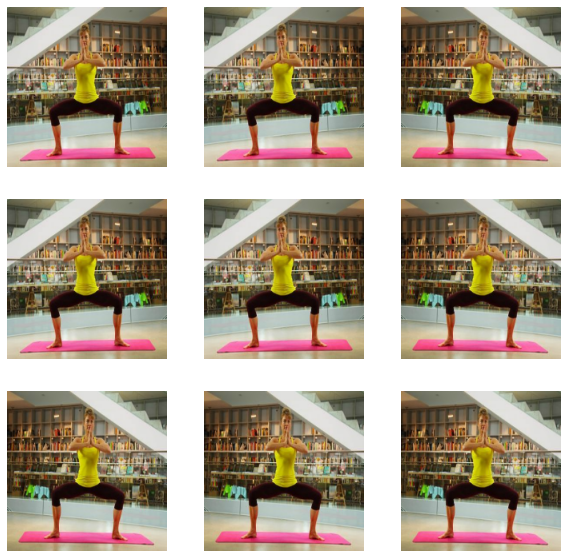

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [35]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = inputs

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=(200,200) + (3,), num_classes=2)


In [36]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 200, 200, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 100, 100, 32) 896         rescaling_2[0][0]                
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 100, 100, 32) 128         conv2d_12[0][0]                  
_______________________________________________________________________________________

In [41]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/5
11/11 [==============================] - 62s 6s/step - loss: 0.2576 - accuracy: 0.9226 - val_loss: 0.6935 - val_accuracy: 0.4857
Epoch 2/5
11/11 [==============================] - 64s 6s/step - loss: 0.2665 - accuracy: 0.9102 - val_loss: 0.6936 - val_accuracy: 0.4857
Epoch 3/5
11/11 [==============================] - 64s 6s/step - loss: 0.2239 - accuracy: 0.9567 - val_loss: 0.6937 - val_accuracy: 0.4857
Epoch 4/5
11/11 [==============================] - 65s 6s/step - loss: 0.2083 - accuracy: 0.9474 - val_loss: 0.6940 - val_accuracy: 0.4857
Epoch 5/5
11/11 [==============================] - 63s 6s/step - loss: 0.2009 - accuracy: 0.9628 - val_loss: 0.6944 - val_accuracy: 0.4857


In [40]:
img = keras.preprocessing.image.load_img(
    "test2.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent downdog and %.2f percent goddess."
    % (100 * (1 - score), 100 * score)
)

This image is 50.47 percent downdog and 49.53 percent goddess.


In [57]:
import efficientnet.keras as efn
from keras.layers import Flatten,Dense,Dropout
from keras import Model

In [48]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.,horizontal_flip = True)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(directory=r"./DATASET/TRAIN", batch_size = 20, class_mode = 'binary', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory(directory=r"./DATASET/TEST", batch_size = 20, class_mode = 'binary', target_size = (224, 224))


Found 403 images belonging to 2 classes.
Found 177 images belonging to 2 classes.


In [49]:
base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')


16809984/16804768 [==============================] - 44s 3us/step


In [50]:
for layer in base_model.layers:
    layer.trainable = False

In [60]:
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)
model_final = Model(model.input,predictions)

In [66]:
model_final.compile(tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6),loss='binary_crossentropy',metrics=['accuracy'])


In [67]:
eff_history = model_final.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 10, epochs = 10)


Epoch 1/10
10/10 [==============================] - 49s 5s/step - loss: 0.6683 - accuracy: 0.8306 - val_loss: 0.6968 - val_accuracy: 0.4520
Epoch 2/10
10/10 [==============================] - 49s 5s/step - loss: 0.6599 - accuracy: 0.8689 - val_loss: 0.6969 - val_accuracy: 0.4520
Epoch 3/10
10/10 [==============================] - 52s 5s/step - loss: 0.6634 - accuracy: 0.8251 - val_loss: 0.6970 - val_accuracy: 0.4520
Epoch 4/10
10/10 [==============================] - 55s 6s/step - loss: 0.6617 - accuracy: 0.8700 - val_loss: 0.6971 - val_accuracy: 0.4520
Epoch 5/10
10/10 [==============================] - 55s 6s/step - loss: 0.6581 - accuracy: 0.8950 - val_loss: 0.6973 - val_accuracy: 0.4520
Epoch 6/10
10/10 [==============================] - 51s 5s/step - loss: 0.6562 - accuracy: 0.8907 - val_loss: 0.6975 - val_accuracy: 0.4520
Epoch 7/10
10/10 [==============================] - 49s 5s/step - loss: 0.6601 - accuracy: 0.8634 - val_loss: 0.6976 - val_accuracy: 0.4520
Epoch 8/10
10/10 [==

In [ ]:
img = keras.preprocessing.image.load_img(
    "test2.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model_final.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent downdog and %.2f percent goddess."
    % (100 * (1 - score), 100 * score)
)